In [3]:
# DTSC-680: Applied Machine Learning
## Convolutional Neural Networks

## Table of Contents

1. [Pretrained CNNs](#Pretrained)
2. [Using ResNet50V2 to Classify Images](#ResNet)
3. [Using Transfer Learning to Identify Arctic Wildlife](#arctic)
4. [Data Augmentation](#augment)
5. [Global Pooling](#pooling)

In [4]:
# common imports
import numpy as np
import pandas as pd

## Pretrained CNNs<a name="Pretrained"></a>
Many large tech companies use images from the [ImageNet dataset](https://www.image-net.org/download.php) to train state-of-the-art CNNs for object detection that are made available for public use. Keras has over [two dozen popular pretrained CNNs](https://keras.io/api/applications/) available for use.

Let's take a look at the [MobileNetV2](https://keras.io/api/applications/mobilenet/) from Keras.

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

model = MobileNetV2(weights='imagenet')

2024-09-20 16:03:59.104446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now we can pass an image to our network for classification. We resize the image to the dimensions of the CNN and preprocess it.

In [6]:
import numpy as np
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image

x = image.load_img('data/arctic_fox_100.jpeg', target_size=(224, 224))
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

Finally, we can use the network to make a prediction with the predict function.

In [7]:
y = model.predict(x)

1/1 [==============================] - 2s 2s/step


To interpret the results of the prediction, we can use Keras network-specific decode_predictions method.

In [8]:
from tensorflow.keras.applications.imagenet_utils import decode_predictions
y = decode_predictions(y)
y

[[('n02120079', 'Arctic_fox', 0.6480789),
  ('n02120505', 'grey_fox', 0.1275997),
  ('n02119789', 'kit_fox', 0.06658018),
  ('n02114548', 'white_wolf', 0.052692585),
  ('n02442845', 'mink', 0.005789312)]]

## Using ResNet50V2 to Classify Images<a name="ResNet"></a>

[ResNet50V2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50V2) is another pretrained CNN that is available to us through Keras. We will be using this network to classify a pair of images.

In [9]:
from tensorflow.keras.applications import ResNet50V2

model = ResNet50V2(weights='imagenet')

Load an Arctic fox image and display it.

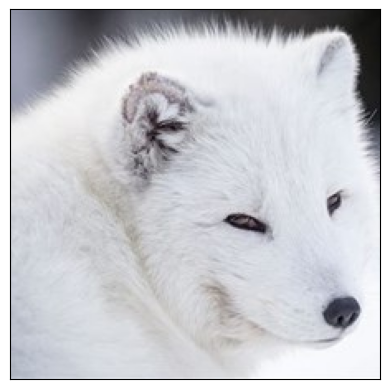

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
x = image.load_img('data/arctic_fox_140.jpeg',

target_size=(224, 224))

plt.xticks([])
plt.yticks([])
plt.imshow(x)

Preprocess the image. Note that with ResNet50V2, you have to divide all the pixel values by 255 after calling Kera's preprocess_input method. Pass the processed image to the network for classification and interpret the results.

In [11]:
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions

# preprocess the image
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) / 255

# pass the processed image to the network and interpret the results
y = model.predict(x)
y = decode_predictions(y)
y

1/1 [==============================] - 1s 1s/step


[[('n02120079', 'Arctic_fox', 0.9999944),
  ('n02114548', 'white_wolf', 4.7600256e-06),
  ('n02119789', 'kit_fox', 2.3306782e-07),
  ('n02442845', 'mink', 1.246036e-07),
  ('n02111889', 'Samoyed', 1.1914502e-07)]]

Use ResNet50V2 to classify the below image of a walrus.

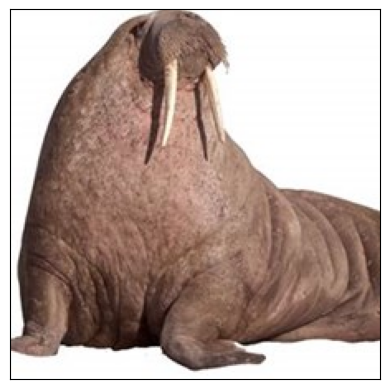

In [12]:
x = image.load_img('data/walrus_143.png', target_size=(224, 224))

plt.xticks([])
plt.yticks([])
plt.imshow(x)

In [13]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) / 255

y = model.predict(x)
y = decode_predictions(y)
y

1/1 [==============================] - 0s 210ms/step


[[('n02454379', 'armadillo', 0.63758177),
  ('n01704323', 'triceratops', 0.16057025),
  ('n02113978', 'Mexican_hairless', 0.077950746),
  ('n02398521', 'hippopotamus', 0.022284094),
  ('n01817953', 'African_grey', 0.01694407)]]

ResNet50V2 thinks that this is most likely an image of an armadillo. Why might this be the case?

ResNet50V2 was trained with [1.3 million images](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/), but none of those images contained a walrus. CNNs are powerful networks for classifying images that they were trained to classify, but they cannot handle domain-specific tasks that they were not trained for. A technique called transfer learning can help.

## Using Transfer Learning to Identify Arctic Wildlife<a name="arctic"></a>

Transfer learning is a technique for repurposing pretrained CNNs to identify objects that they weren't originally trained to identify.

Recall the two layers of a CNN:
- the bottleneck layers (containing the convolution and pooling layers) that extract features from images
- classification layers that classify the features as belonging to one of the classes.

With transfer learning, you load the bottleneck layers of a pretrained CNN, but not the classification layers. During training, the training images are passed through the already trained bottleneck layers for feature extraction and the classification layers are trained on the resulting features.

Let's load our images.

In [14]:
import os

def load_images_from_path(path, label):
    images, labels = [], []

    for file in os.listdir(path):
        img = image.load_img(os.path.join(path, file), target_size=(224, 224, 3))
        images.append(image.img_to_array(img))
        labels.append((label))
    return images, labels

def generate_sets():
    x_train = []
    y_train = []
    x_test = []
    y_test = []

    images, labels = load_images_from_path('data/train/arctic_fox', 0)
    x_train+=images
    y_train+=labels
    images, labels = load_images_from_path('data/test/arctic_fox', 0)
    x_test+=images
    y_test+=labels

    images, labels = load_images_from_path('data/train/polar_bear', 1)
    x_train+=images
    y_train+=labels
    images, labels = load_images_from_path('data/test/polar_bear', 1)
    x_test+=images
    y_test+=labels

    images, labels = load_images_from_path('data/train/walrus', 2)
    x_train+=images
    y_train+=labels
    images, labels = load_images_from_path('data/test/walrus', 2)
    x_test+=images
    y_test+=labels

    x_train = preprocess_input(np.array(x_train)) / 255
    x_test = preprocess_input(np.array(x_test)) / 255
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = generate_sets()

We can load the pretrained ResNet50V2 model and initialize it with the weights, kernel values, and biases from it's original training without the classification layers by setting the `include_top` parameter to `False`.

In [15]:
base_model = ResNet50V2(weights='imagenet', include_top=False)

Run all of the training images through the base model for feature extraction.

In [16]:
x_train = base_model.predict(x_train)
x_test = base_model.predict(x_test)
base_model.output

4/4 [==============================] - 14s 3s/step


<KerasTensor: shape=(None, None, None, 2048) dtype=float32 (created by layer 'post_relu')>

Create your network of classification layers and run the features through the model.

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# create classification layers
model = Sequential()
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# run the features through the classification layers
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=10)

Epoch 1/10
30/30 [==============================] - 20s 514ms/step - loss: 7.5022 - accuracy: 0.8933 - val_loss: 12.0574 - val_accuracy: 0.9500
Epoch 2/10
30/30 [==============================] - 16s 510ms/step - loss: 2.7588 - accuracy: 0.9767 - val_loss: 17.8547 - val_accuracy: 0.9500
Epoch 3/10
30/30 [==============================] - 19s 625ms/step - loss: 2.2404 - accuracy: 0.9767 - val_loss: 12.0242 - val_accuracy: 0.9417
Epoch 4/10
30/30 [==============================] - 18s 603ms/step - loss: 1.4991 - accuracy: 0.9900 - val_loss: 10.8771 - val_accuracy: 0.9583
Epoch 5/10
30/30 [==============================] - 17s 583ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 11.1677 - val_accuracy: 0.9500
Epoch 6/10
30/30 [==============================] - 19s 638ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 11.2182 - val_accuracy: 0.9500
Epoch 7/10
30/30 [==============================] - 19s 623ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 11.2206 - v

Your textbook outlines another technique used for transfer learning that appends the classifiction layers onto the base model's bottleneck layers before running the training images through the entire network. See the textbook for more details.

Let's plot the training accuracy and the validation accuracy for each epoch to see how the network trained.

[]

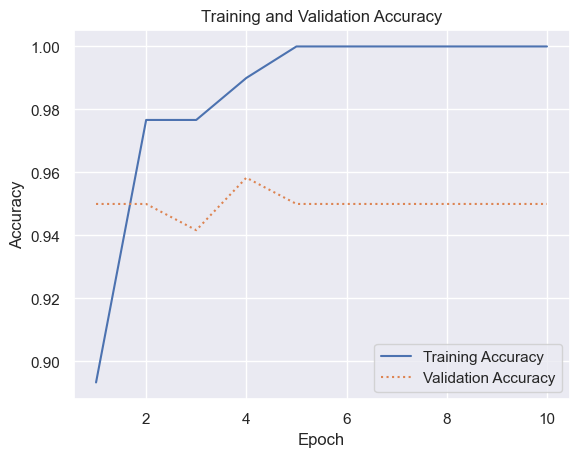

In [18]:
import seaborn as sns

sns.set()

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

As we can see, the model has over 89% accuracy through each epoch.

Let's take a look at the confusion matrix.

4/4 [==============================] - 1s 208ms/step


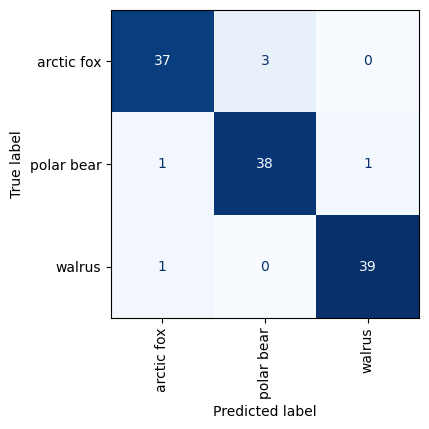

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay as cmd

sns.reset_orig()
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(False)

y_pred = model.predict(x_test)
class_labels = ['arctic fox', 'polar bear', 'walrus']

cmd.from_predictions(y_test, y_pred.argmax(axis=1),

display_labels=class_labels, colorbar=False,
cmap='Blues', xticks_rotation='vertical', ax=ax)

Again, we can see that the model performs pretty well.

Recall that the ResNet50V2 network was not trained using images of walruses, which is whyb it was not able to classify the walrus before transfer learning. Our current model trained the classification layers using images of walruses. Let's use the model to classify the below image of a walrus.

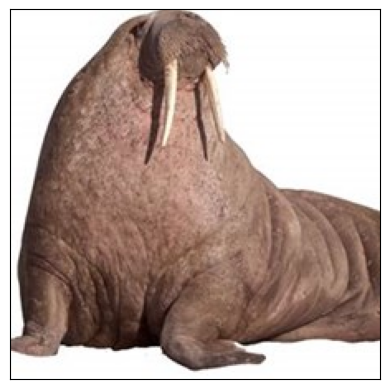

In [20]:
x = image.load_img('data/walrus_143.png', target_size=(224, 224))

plt.xticks([])
plt.yticks([])
plt.imshow(x)

In [21]:
# preprocess the images
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) / 255

# pass the processed images to the base model
y = base_model.predict(x)

# pass the features from the image to the model's predict method
predictions = model.predict(y)

for i, label in enumerate(class_labels):
    print(f'{label}: {predictions[0][i]}')

1/1 [==============================] - 0s 62ms/step
arctic fox: 0.0
polar bear: 0.0
walrus: 1.0


Using transfer learning, we were able to take a pretrained CNN and modify it to fit our domain-specific problem: walrus image classification.

## Data Augmentation<a name="augment"></a>

As we have seen, transfer learning allows models to learn for domain-specific problems with relatively little training data. However, a small amount of training data could lead to the model having trouble classifying samples with small modifications.

Our Arctic Wildlife model, for example, was trained with 100 images for each class. If each polar bear image showed the head of the polar bear aligned well in the center of the image, then the model would likely struggle to classify a polar bear image if the polar bear's head was tilted in a different angle or off to the side of the image.

One solution to this problem is data augmentation. Data augmentation is the process of rotating, translating, and scaling images in the training set to increase the variation in the images. Below is an example of the same hot dog image randomly transformed in 8 different ways.

<img src="data/hotdogs.jpeg" width="800" height="500">

We will use Kera's [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class to apply image augmentation to our Arctic Wildlife images. First, load an image.

In [22]:
# Load an image
x = image.load_img('data/train/polar_bear/polar_bear_010.jpeg')
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)

Create an `ImageDataGenerator` object. The parameters passed to the `ImageDataGenerator` tell it how to transform each image it delivers:
- `rescale=1./255` divides each pixel by 255
- `horizontal_flip=True` randomly flips the image horizontally (around the vertical axis)
- `rotation_range=30` randomly rotates the image by -30 to 30 degrees
- `width_shift_range=0.2` and `height_shift_range=0.2` randomly translates the image by -20% to 20%
- `zoom_range=0.2` randomly scales the image by -20% to 20%
- Other parameters such as `vertical_flip`, `shear_range`, and `brightness_range` can be found in the [`ImageDataGenerator` documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

The `fit` method wraps the `ImageDataGenerator` object around the sample image.

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

idg = ImageDataGenerator(rescale=1./255,
                         horizontal_flip=True,
                         rotation_range=30,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         zoom_range=0.2)

idg.fit(x)

Generate 24 versions of the image using the `flow` method.

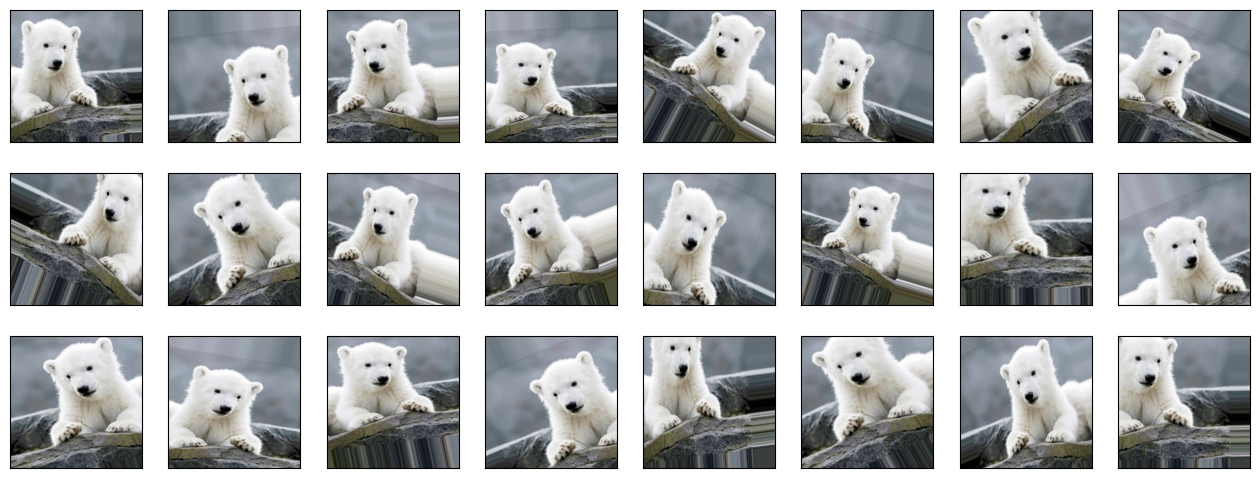

In [24]:
generator = idg.flow(x, [0], batch_size=1, seed=0)
fig, axes = plt.subplots(3, 8, figsize=(16, 6), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img, label = generator.next()
    ax.imshow(img[0])

The generater that is returned by the `flow` method can be passed directly to a model's `fit` method to provide randomly transformed images to the model as it is trained.

Consider the code below. The `batch_size` parameter passed to the `flow` method tells the generator to create 10 images in each batch. The `steps_per_epoch` parameter limits the `ImageDataGenerator` to a certain number of versions of each image. We divide the number of images by the image batch size to ensure that the model is provided with one transformed version of each image during each training epoch.

In [25]:
# Create an ImageDataGenerator object
idg = ImageDataGenerator(rescale=1./255,
                         horizontal_flip=True,
                         rotation_range=30,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         zoom_range=0.2)

# Wrap the ImageDataGenerator object around the training files
idg.fit(x_train)

# Generate randomly transformed images
image_batch_size = 10
generator = idg.flow(x_train, y_train, batch_size=image_batch_size, seed=0)

# Train a model using the randomly transformed images
model.fit(generator,
          steps_per_epoch=len(x_train) // image_batch_size,
          validation_data=(x_test, y_test),
          batch_size=20,
          epochs=10)

/opt/anaconda3/envs/dtsc680/lib/python3.8/site-packages/keras/preprocessing/image.py:1874: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (300, 7, 7, 2048) (2048 channels).
  warnings.warn('Expected input to be images (as Numpy array) '
/opt/anaconda3/envs/dtsc680/lib/python3.8/site-packages/keras/preprocessing/image.py:680: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (300, 7, 7, 2048) (2048 channels).
  warnings.warn('NumpyArrayIterator is set to use the '


Epoch 1/10
30/30 [==============================] - 36s 1s/step - loss: 0.1372 - accuracy: 0.9800 - val_loss: 10.6222 - val_accuracy: 0.9667
Epoch 2/10
30/30 [==============================] - 30s 995ms/step - loss: 0.0450 - accuracy: 0.9900 - val_loss: 14.8428 - val_accuracy: 0.9750
Epoch 3/10
30/30 [==============================] - 29s 971ms/step - loss: 0.0260 - accuracy: 0.9933 - val_loss: 16.6554 - val_accuracy: 0.9750
Epoch 4/10
30/30 [==============================] - 31s 1s/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 14.5247 - val_accuracy: 0.9833
Epoch 5/10
30/30 [==============================] - 29s 957ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 15.6726 - val_accuracy: 0.9833
Epoch 6/10
30/30 [==============================] - 28s 938ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 15.9106 - val_accuracy: 0.9750
Epoch 7/10
30/30 [==============================] - 29s 959ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 16.3099 - val_accuracy: 0.983

[]

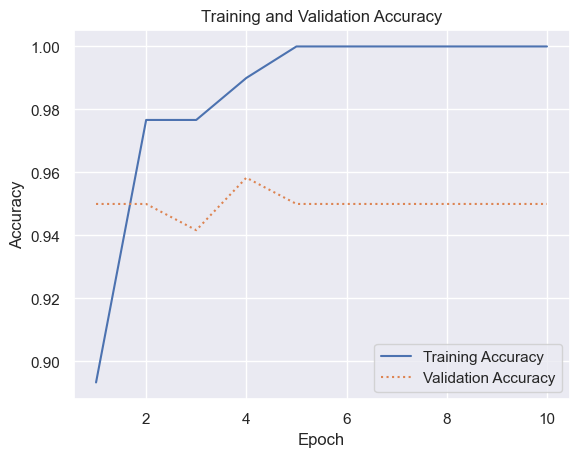

In [26]:
sns.set()

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

By comparing this plot to the previous, we can see that the validation accuracy of the transfer learning model when trained with data augmentation performs even better than when trained without data augmentation.

## Global Pooling<a name="pooling"></a>

Consider our model for classifying wildlife with transfer learning:

`
model = Sequential()
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])`

The `Flatten` layer reshapes the 3D tensors containing the feature maps into 1D tensors suitable for input into a `Dense` layer. Using a `Flatten` layer, however, can sometimes lead to overfitting by providing too much information to the classification layers.

One way to combat overfitting is to introduce a `Dropout` layer. Another strategy is to reduce the width of the `Dense` layer. A third option is to replace the `Flatten` layer with a [`GlobalMaxPooling2D` layer](https://keras.io/api/layers/pooling_layers/global_max_pooling2d/) or a [`GlobalAveragePooling2D` layer](https://keras.io/api/layers/pooling_layers/global_average_pooling2d/), which both output 1D tensors which are generated in such a way that makes them less prone to overfitting.

Let's use this strategy to classify handwritten digits from the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), whose first 50 samples are pictured below.

<img src="data/mnist.jpeg">

Load the dataset and reshape the 28 $\times$ 28 images into 28 $\times$ 28 $\times$ 1 arrays. Normalize the arrays by dividing the pixel values by 255.

In [27]:
from tensorflow.keras.datasets import mnist

(train_images, y_train), (test_images, y_test) = mnist.load_data()
x_train = train_images.reshape(60000, 28, 28, 1) / 255
x_test = test_images.reshape(10000, 28, 28, 1) / 255

Define a CNN that accepts 28 $\times$ 28 $\times$ 1 arrays of pixel values as input and uses a `GlobalMaxPooling2D` layer in lieu of the `Flatten` layer.

In [28]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(GlobalMaxPooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary(line_length=120)

Model: "sequential_1"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 conv2d (Conv2D)                                      (None, 26, 26, 32)                              320               
                                                                                                                        
 max_pooling2d_6 (MaxPooling2D)                       (None, 13, 13, 32)                              0                 
                                                                                                                        
 conv2d_1 (Conv2D)                                    (None, 11, 11, 64)                              18496             
                                                                                                                        
 max_pooli

As we can see from the summary, the output from the `GlobalMaxPooling2D` layer is a tensor containing 64 values, which is one value per feature map output by the `MaxPooling2D` layer. Each value is the maximum of the 25 values in each 5 $\times$ 5 feature map.

Train the network and plot the training and validation accuracy.

In [29]:
sns.set()

# Train the model
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=50)

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plot the accuracy
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Epoch 1/10
1007/1200 [========================>.....] - ETA: 9s - loss: 0.4937 - accuracy: 0.8497

KeyboardInterrupt: 

Now we have successfully trained a model to identify handwritten digits using global pooling.

Your textbook also contains techniques on training audio files with CNNs in addition to image files. See the textbook for more information.